In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from itertools import product
from tqdm.notebook import tqdm
sns.set()

# Data Description (copied from Kaggle)

The training dataset consists of approximately 145k time series. Each of these time series represent a number of daily views of a different Wikipedia article, starting from July, 1st, 2015 up until December 31st, 2016. The leaderboard during the training stage is based on traffic from January, 1st, 2017 up until March 1st, 2017.

The second stage will use training data up until September 1st, 2017. The final ranking of the competition will be based on predictions of daily views between September 13th, 2017 and November 13th, 2017 for each article in the dataset. You will submit your forecasts for these dates by September 12th.

For each time series, you are provided the name of the article as well as the type of traffic that this time series represent (all, mobile, desktop, spider). You may use this metadata and any other publicly available data to make predictions. Unfortunately, the data source for this dataset does not distinguish between traffic values of zero and missing values. A missing value may mean the traffic was zero or that the data is not available for that day.

To reduce the submission file size, each page and date combination has been given a shorter Id. The mapping between page names and the submission Id is given in the key files.

File descriptions
Files used for the first stage will end in '_1'. Files used for the second stage will end in '_2'. Both will have identical formats. The complete training data for the second stage will be made available prior to the second stage.

- **train_*.csv** - contains traffic data. This a csv file where each row corresponds to a particular article and each column correspond to a particular date. Some entries are missing data. The page names contain the Wikipedia project (e.g. en.wikipedia.org), type of access (e.g. desktop) and type of agent (e.g. spider). In other words, each article name has the following format: 'name_project_access_agent' (e.g. 'AKB48_zh.wikipedia.org_all-access_spider').
- **key_*.csv** - gives the mapping between the page names and the shortened Id column used for prediction
- **sample_submission_*.csv** - a submission file showing the correct format

In [2]:
raw_data_folder = Path(r'E:\Documentos\Machine Learning\Kaggle\Web Traffic Time Series Forecasting')
raw_train1_file = r'train_1.csv'
raw_train2_file = r'train_2.csv'
raw_train1_df = pd.read_csv(raw_data_folder / raw_train1_file)
raw_train2_df = pd.read_csv(raw_data_folder / raw_train2_file)

In [3]:
raw_train1_df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [4]:
raw_train2_df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


Given the datasets above and the data description, the **train_2.csv** have the complete data, while the **train_1.csv** have only a subset of the data. So, we will use only **train_2.csv**

In [5]:
del raw_train1_df

Let's study the first page:

In [6]:
n_page = 0
raw_time_series = raw_train2_df.loc[n_page].drop('Page')
print('Page: {}'.format(raw_train2_df.loc[n_page, 'Page']))
raw_time_series.index = pd.to_datetime(raw_time_series.index.values, format='%Y-%m-%d')
raw_time_series.index.freq = 'D'
raw_time_series.sort_index(ascending=True, inplace=True) #just to be sure that the dates are sorted

Page: 2NE1_zh.wikipedia.org_all-access_spider


In [7]:
raw_time_series.head()

2015-07-01    18
2015-07-02    11
2015-07-03     5
2015-07-04    13
2015-07-05    14
Freq: D, Name: 0, dtype: object

Are there any NaNs?

In [8]:
raw_time_series[raw_time_series.isna()]

Series([], Freq: D, Name: 0, dtype: object)

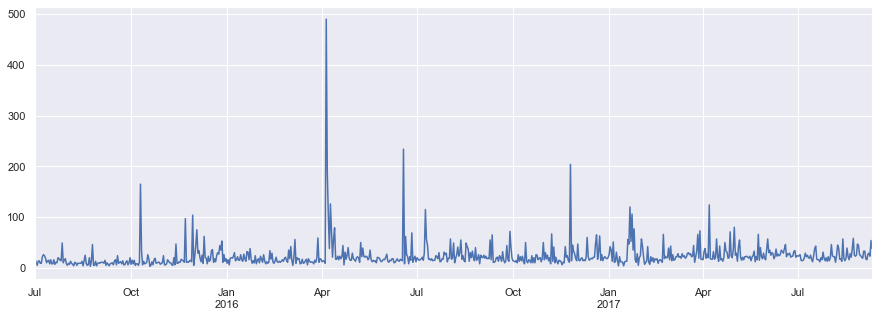

In [9]:
raw_time_series.plot(figsize=(15, 5));

In [10]:
df_time_series = pd.DataFrame(raw_time_series)
rename_dict = {0:'value'}
df_time_series.rename(columns=rename_dict, inplace=True)
df_time_series['day_of_week'] = df_time_series.index.dayofweek
df_time_series['day_name'] = df_time_series.index.day_name()
df_time_series['day_of_year'] = df_time_series.index.dayofyear
df_time_series['is_weekend'] = df_time_series.index.day_name().map(lambda x: True if x in ['Saturday', 'Sunday'] else False)
df_time_series['month'] = df_time_series.index.month
df_time_series['month_name'] = df_time_series.index.month_name()
df_time_series.value = df_time_series.value.map(float)

In [11]:
df_time_series.head()

,value,day_of_week,day_name,day_of_year,is_weekend,month,month_name
2015-07-01,18.0,2,Wednesday,182,False,7,July
2015-07-02,11.0,3,Thursday,183,False,7,July
2015-07-03,5.0,4,Friday,184,False,7,July
2015-07-04,13.0,5,Saturday,185,True,7,July
2015-07-05,14.0,6,Sunday,186,True,7,July


#### What are the days which people access this page the most?

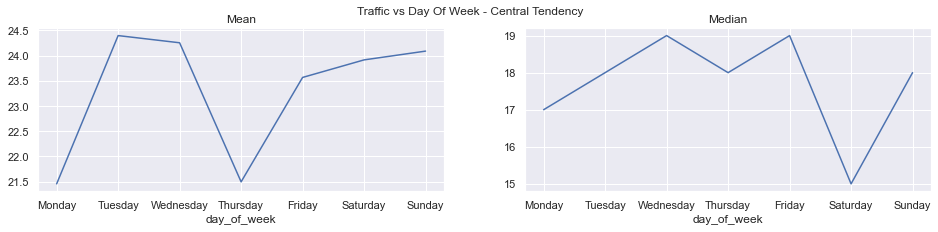

In [12]:
dict_day = {
    0:'Monday',
    1:'Tuesday',
    2:'Wednesday',
    3:'Thursday',
    4:'Friday',
    5:'Saturday',
    6:'Sunday'
}
df_grouped_mean = df_time_series.groupby('day_of_week').mean()
df_grouped_mean.index = df_grouped_mean.index.map(lambda x: dict_day[x])

df_grouped_median = df_time_series.groupby('day_of_week').median()
df_grouped_median.index = df_grouped_median.index.map(lambda x: dict_day[x])

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(16,3))
fig.suptitle('Traffic vs Day Of Week - Central Tendency')

df_grouped_mean.value.plot(ax=axes[0]);
axes[0].set_title('Mean');
df_grouped_median.value.plot(ax=axes[1]);
axes[1].set_title('Median');

Why so different plots?

Hipothesis: there are outliers within the series (for instance, if it's a christmas themed page, the traffic goes up only near christmas)

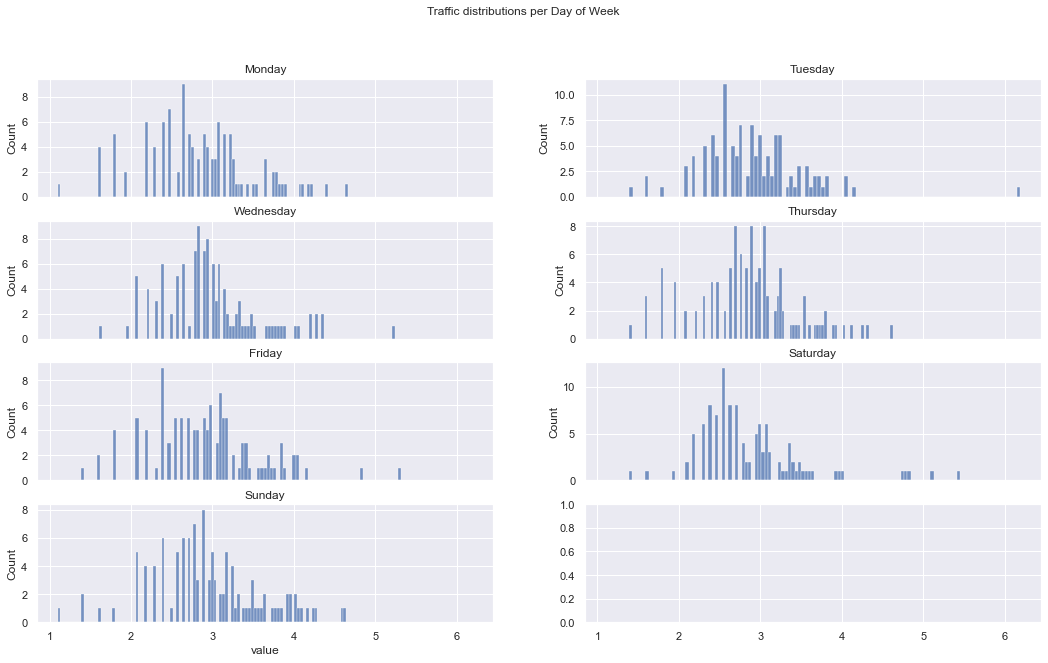

In [13]:
#Using log transformation so that the scale can be better interpreted
bins=100
fig, axes = plt.subplots(4, 2, sharex=True, figsize=(18,10))
fig.suptitle('Traffic distributions per Day of Week')

sns.histplot(df_time_series[df_time_series.day_name == 'Monday'].value.map(lambda x: np.log(x)), ax=axes[0][0], bins=bins);
axes[0][0].set_title('Monday');

sns.histplot(df_time_series[df_time_series.day_name == 'Tuesday'].value.map(lambda x: np.log(x)), ax=axes[0][1], bins=bins);
axes[0][1].set_title('Tuesday');

sns.histplot(df_time_series[df_time_series.day_name == 'Wednesday'].value.map(lambda x: np.log(x)), ax=axes[1][0], bins=bins);
axes[1][0].set_title('Wednesday');

sns.histplot(df_time_series[df_time_series.day_name == 'Thursday'].value.map(lambda x: np.log(x)), ax=axes[1][1], bins=bins);
axes[1][1].set_title('Thursday');

sns.histplot(df_time_series[df_time_series.day_name == 'Friday'].value.map(lambda x: np.log(x)), ax=axes[2][0], bins=bins);
axes[2][0].set_title('Friday');

sns.histplot(df_time_series[df_time_series.day_name == 'Saturday'].value.map(lambda x: np.log(x)), ax=axes[2][1], bins=bins);
axes[2][1].set_title('Saturday');

sns.histplot(df_time_series[df_time_series.day_name == 'Sunday'].value.map(lambda x: np.log(x)), ax=axes[3][0], bins=bins);
axes[3][0].set_title('Sunday');

So, the median distribution is the best one. **Wednesday and Friday** are the days in which people access this page the most.

#### Is the page traffic related to the month?

In [14]:
dict_month = {
    0:'Jan',
    1:'Feb',
    2:'Mar',
    3:'Apr',
    4:'May',
    5:'Jun',
    6:'Jul',
    7:'Aug',
    8:'Sept',
    9:'Oct',
    10:'Nov',
    11:'Dec'
}
df_grouped_mean = df_time_series.groupby('month').mean()
df_grouped_mean.index = df_grouped_mean.index.map(lambda x: dict_month[x-1])

<AxesSubplot:xlabel='month'>

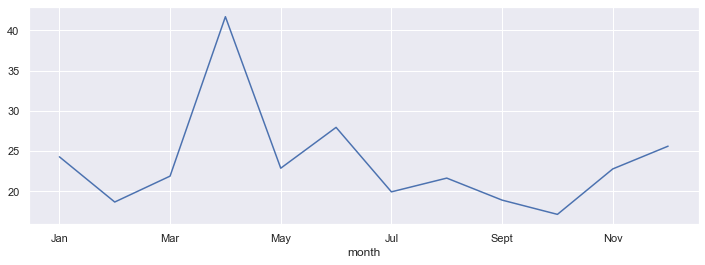

In [15]:
df_grouped_mean.value.plot(figsize=(12,4))

Apparently the traffic goes up on April and June.

In [16]:
df_time_series.month.value_counts().sort_index()

1     62
2     57
3     62
4     60
5     62
6     60
7     93
8     93
9     70
10    62
11    60
12    62
Name: month, dtype: int64

#### Decomposition

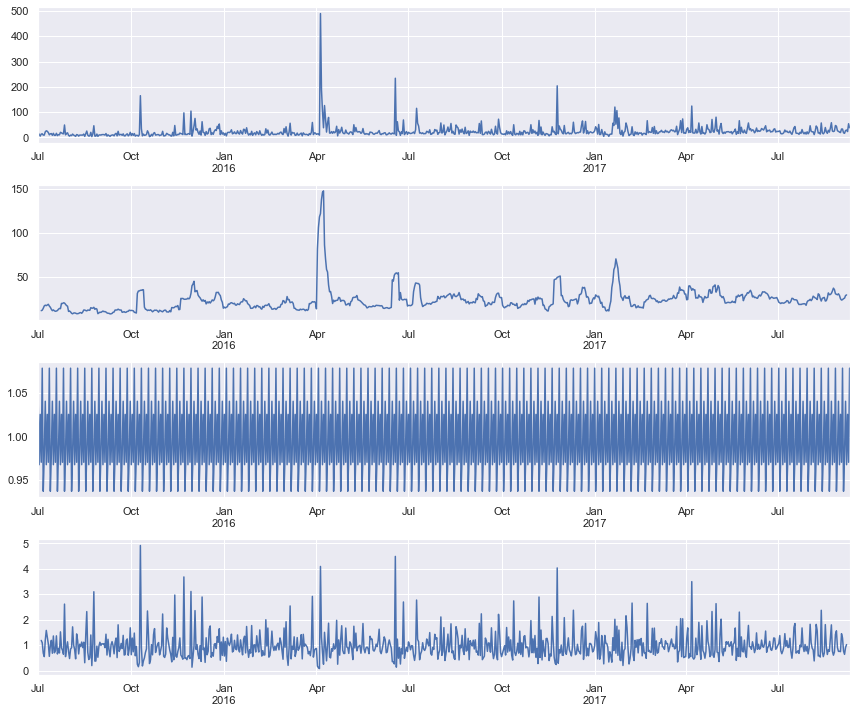

In [17]:
result = seasonal_decompose(df_time_series.value, model='multiplicative')

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(12,10))
result.observed.plot(ax=ax1)
result.trend.plot(ax=ax2)
result.seasonal.plot(ax=ax3)
result.resid.plot(ax=ax4)
plt.tight_layout()

#### Stationarity

In [18]:
result = adfuller(df_time_series.value)
print('Augmented Dickey Fuller')
print('Statistical test: {:.4f}'.format(result[0]))
print('p-value: {:.4f}'.format(result[1]))
print('Critical values:')
for key, value in result[4].items():
    print('\t{}: {:.4f}'.format(key, value))

Augmented Dickey Fuller
Statistical test: -10.6891
p-value: 0.0000
Critical values:
	1%: -3.4386
	5%: -2.8652
	10%: -2.5687


The time series is stationary

#### Model

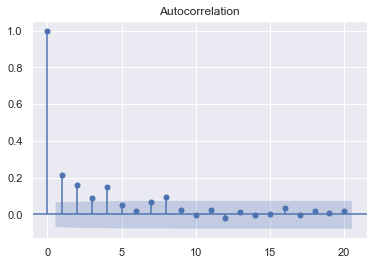

In [19]:
plot_acf(df_time_series.value, lags=20);

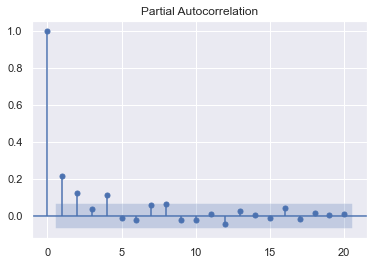

In [20]:
plot_pacf(df_time_series.value, lags=20);

In [21]:
model = ARIMA(df_time_series.value, order=(5,0,1))
result_AR = model.fit()

<AxesSubplot:>

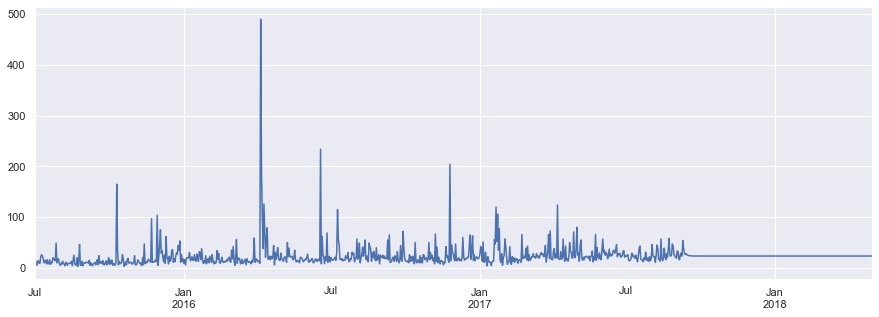

In [22]:
df_time_series.value.append(result_AR.predict(start="2017-09-11", end="2018-05-01")).plot(figsize=(15,5))

In [23]:
#taken from https://towardsdatascience.com/advanced-time-series-analysis-with-arma-and-arima-a7d9b589ed6d
def optimize_ARIMA(order_list, series):
    results = []
    for order in tqdm(order_list):
        try: 
            model = SARIMAX(endog=series, order=order).fit(disp=-1)
        except Exception as e:
            print(e)
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [24]:
p_max = 6
d_max = 1
q_max = 6
ps = range(0, p_max + 1, 1)
ds = range(0, d_max + 1, 1)
qs = range(0, q_max + 1, 1)
# Create a list with all possible combination of parameters
parameters = product(ps, ds, qs)
order_list = list(parameters)

In [25]:
result_df = optimize_ARIMA(order_list, series=df_time_series.value)

C:\ProgramData\Anaconda3\envs\wikipedia-web-traffic\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\envs\wikipedia-web-traffic\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\envs\wikipedia-web-traffic\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\envs\wikipedia-web-traffic\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\envs\wikipedia-web-traffic\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible startin

C:\ProgramData\Anaconda3\envs\wikipedia-web-traffic\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\envs\wikipedia-web-traffic\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\envs\wikipedia-web-traffic\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\envs\wikipedia-web-traffic\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


C:\ProgramData\Anaconda3\envs\wikipedia-web-traffic\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [26]:
result_df.head()

,"(p, d, q)",AIC
0,"(4, 1, 3)",7463.978291
1,"(4, 1, 1)",7464.394774
2,"(0, 1, 5)",7465.057099
3,"(2, 1, 5)",7465.284331
4,"(5, 1, 3)",7465.820630


In [27]:
best_model = SARIMAX(df_time_series.value, order=(4,1,3)).fit()
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  803
Model:               SARIMAX(4, 1, 3)   Log Likelihood               -3723.989
Date:                Mon, 30 Nov 2020   AIC                           7463.978
Time:                        15:03:55   BIC                           7501.475
Sample:                    07-01-2015   HQIC                          7478.381
                         - 09-10-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0346      0.292     -0.118      0.906      -0.608       0.539
ar.L2         -0.4188      0.280     -1.496      0.135      -0.968       0.130
ar.L3          0.1205      0.072      1.675      0.0

C:\ProgramData\Anaconda3\envs\wikipedia-web-traffic\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


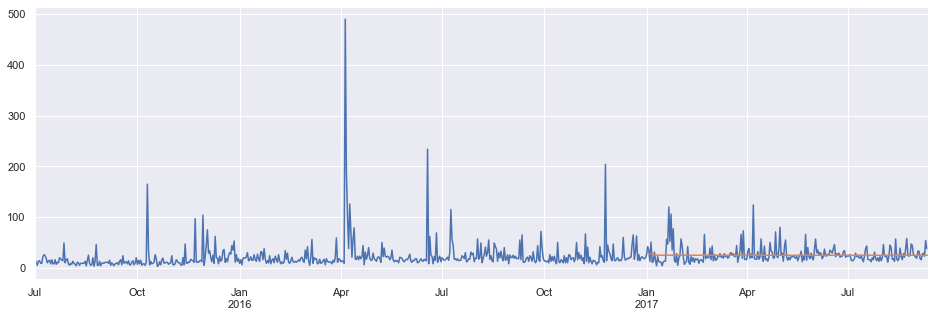

In [28]:
plt.figure(figsize=(16,5))
df_time_series.value.plot();
days_delta = 250
last_day = df_time_series.index[-days_delta]

best_model = SARIMAX(df_time_series.value[:-days_delta], order=(4,1,3)).fit()
best_model.predict(start=last_day, end=last_day + pd.Timedelta(str(days_delta)+' days')).plot();

In [29]:
# Ljung-Box test
#H0 -> residuals have no autocorrelation
#H1 -> residuals have autocorrelation
ljung_box, p_value = acorr_ljungbox(best_model.resid)
print(f'Ljung-Box test: {ljung_box[:10]}')
print(f'p-value: {p_value[:10]}')

Ljung-Box test: [0.01373437 0.02677148 0.03031247 0.12976995 0.1562113  0.25661053
 0.50277778 2.95440681 3.14036964 3.28321844]
p-value: [0.90670652 0.98670345 0.99860907 0.99798385 0.99951476 0.99968017
 0.99943625 0.93718607 0.95846856 0.97395172]


C:\ProgramData\Anaconda3\envs\wikipedia-web-traffic\lib\site-packages\statsmodels\stats\diagnostic.py:533: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setlags to silence this warning.
  "lags to silence this warning.", FutureWarning)
C:\ProgramData\Anaconda3\envs\wikipedia-web-traffic\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)
